# Bagging and Random Forests

In this notebook, we will use the Random Forest algorithm to predict if a cyclist will be in the top 20 in the next race or not.

We start by loading the data and preparing the train set and the test set.

In [1]:
import pandas as pd
from os import path
import numpy as np

races_final_path = path.join('..','dataset', 'races_cleaned.csv')
cyclists_final_path = path.join('..','dataset', 'cyclists_cleaned.csv')


cyclists_data = pd.read_csv(cyclists_final_path)
races_data = pd.read_csv(races_final_path)

In [2]:

cyclists_data.rename(columns={'name': 'cyclist'}, inplace=True)


merged_data = races_data.merge(cyclists_data, left_on='cyclist', right_on='_url', how='inner')

merged_data['top_20'] = merged_data['position'].apply(lambda x: 1 if x <= 20 else 0)


merged_data['date'] = pd.to_datetime(merged_data['date'])

columns_to_keep = [
    'points', 'length', 'profile', 'startlist_quality', 'cyclist_age',
    'is_tarmac', 'delta', 'top_20', 'weight', 'height'
]


train_set = merged_data[merged_data['date'] < '2022-01-01']
test_set = merged_data[merged_data['date'] >= '2022-01-01']

train_set = train_set[columns_to_keep]
test_set = test_set[columns_to_keep]

X_train = train_set.drop(columns=['top_20'])
y_train = train_set['top_20']


X_test = test_set.drop(columns=['top_20'])
y_test = test_set['top_20']

So the data is set up however we need to evaluate training data to see which approach works best.

In [3]:
X_train.shape

(554459, 9)

In [4]:
from sklearn.metrics import classification_report
def report_scores(test_label, test_pred):
    print(classification_report(test_label, 
                            test_pred, 
                            target_names=['0', '1']))

In [5]:
#define a decision tree and fit it
from sklearn import tree
dt = tree.DecisionTreeClassifier(criterion='gini', splitter='best', 
                                  max_depth=10, 
                                  min_samples_split=3, min_samples_leaf=4)
dt = dt.fit(X_train, y_train)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.271383 to fit



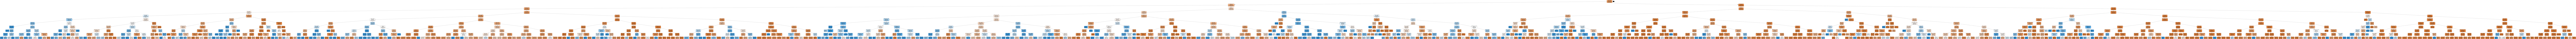

In [ ]:
#visualize the actual decision tree obtained 
import pydotplus 
from IPython.display import Image  
dot_data = tree.export_graphviz(dt, out_file=None, 
                         feature_names=list(X_train.columns),  
                         class_names=['0', '1'],  
                         filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [9]:
#predict using the decision tree
#the predict function returns the actual predicted labels: we need them for the evaluation phase
train_pred_dt = dt.predict(X_train)
test_pred_dt = dt.predict(X_test)


In [12]:
#evaulate the accuracy on the train set and the test set
#metrics also contains precision, recall, f1 and the support
from sklearn import metrics
print('Accuracy train set ', metrics.accuracy_score(y_train, train_pred_dt))
print('Accuracy test set ', metrics.accuracy_score(y_test, test_pred_dt))
print('Precision train set ', metrics.precision_score(y_train, train_pred_dt, average='weighted'))
print('Recall train set ', metrics.recall_score(y_train, train_pred_dt, average='weighted'))
print('F1 score train set ', metrics.f1_score(y_train, train_pred_dt, average='weighted'))
print('Support train set ', metrics.precision_recall_fscore_support(y_train, train_pred_dt))


Accuracy train set  0.8726181737513504
Accuracy test set  0.8605603570016381
Precision train set  0.8611974257547343
Recall train set  0.8726181737513504
F1 score train set  0.8541297413998519
Support train set  (array([0.88373503, 0.75053485]), array([0.97493943, 0.37020732]), array([0.92709955, 0.49583839]), array([460644,  93815]))


In [18]:
#metrics computed on the test set
from sklearn.metrics import classification_report
def report_scores(test_label, test_pred):
    print(classification_report(test_label, 
                            test_pred, 
                            target_names=['0', '1']))

In [19]:
report_scores(y_test, test_pred_dt)

              precision    recall  f1-score   support

           0       0.89      0.95      0.92     30219
           1       0.54      0.32      0.40      5187

    accuracy                           0.86     35406
   macro avg       0.72      0.64      0.66     35406
weighted avg       0.84      0.86      0.85     35406



In [16]:
#cross validation
#the score array for test/train scores on each cv split
#the time for fitting/scoring the estimator on the train set for each cv split
from sklearn.model_selection import cross_validate
import statistics 
scores = cross_validate(dt, X_train, y_train, cv=3, return_train_score= True)
print('Fit time ', statistics.mean(scores['fit_time']))
print('Score time ', statistics.mean(scores['score_time']))
print('Test score ', statistics.mean(scores['test_score']))
print('Train score ', statistics.mean(scores['train_score']))


Fit time  1.0639142195383708
Score time  0.02736488978068034
Test score  0.8494749001504056
Train score  0.874161120426957
